In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import sys
import copy

DRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/IoT_Inverting Gradients'

sys.path.append(DRIVE_PATH)

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image

# Choose variants here:

In [4]:
arch = 'ConvNet64'
num_images = 1
trained_model = False

## System setup:

In [5]:
# Step 1: clone repo
!git clone https://github.com/JonasGeiping/invertinggradients.git

# Step 2: add to Python path
import sys
sys.path.append('/content/invertinggradients')

# Step 3: install dependencies
!pip install torch torchvision tqdm matplotlib

Cloning into 'invertinggradients'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 111 (delta 39), reused 28 (delta 28), pack-reused 52 (from 1)
Receiving objects: 100% (111/111), 2.50 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [6]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR10', defs)

model, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3)
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

Currently evaluating -------------------------------:
Monday, 24. November 2025 07:47AM
CPUs: 1, GPUs: 1 on 50785807b474.
GPU : Tesla T4


100%|██████████| 170M/170M [00:06<00:00, 28.4MB/s]


Model initialized with random key 3219253415.


In [7]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

In [8]:
import os
file_path = os.path.join(DRIVE_PATH, "auto.jpg")

In [9]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open(file_path).resize((32, 32), Image.BICUBIC)) / 255,
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

['automobile']


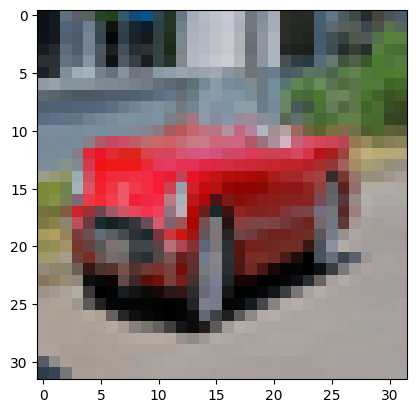

In [10]:
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

In [11]:
local_lr = 1e-4
local_steps = 5
use_updates = True

In [12]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_parameters = inversefed.reconstruction_algorithms.loss_steps(model, ground_truth, labels,
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=use_updates)
input_parameters = [p.detach() for p in input_parameters]

It: 0. Rec. loss: 0.0076.
It: 500. Rec. loss: 0.0026.
It: 1000. Rec. loss: 0.0028.
It: 1500. Rec. loss: 0.0028.
It: 2000. Rec. loss: 0.0029.
It: 2500. Rec. loss: 0.0019.
It: 3000. Rec. loss: 0.0022.
It: 3500. Rec. loss: 0.0020.
It: 3999. Rec. loss: 0.0021.
Choosing optimal result ...
Optimal result score: 0.0021
Total time: 350.52242827415466.


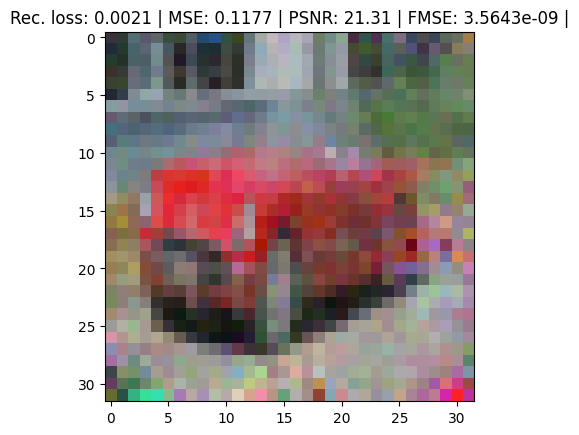

In [13]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=4_000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.FedAvgReconstructor(model, (dm, ds), local_steps, local_lr, config,
                                             use_updates=use_updates)
output, stats = rec_machine.reconstruct(input_parameters, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

In [14]:
# ★ 1) Clean update 적용 후 loss 계산
model_clean = copy.deepcopy(model)  # θ₀ 복사
with torch.no_grad():
    for p, upd in zip(model_clean.parameters(), input_parameters):
        p -= local_lr * upd

loss_clean_after, _, _ = loss_fn(model_clean(ground_truth), labels)
delta_clean = (target_loss - loss_clean_after).item()

In [15]:
stats

defaultdict(list, {'opt': 0.002089381217956543})

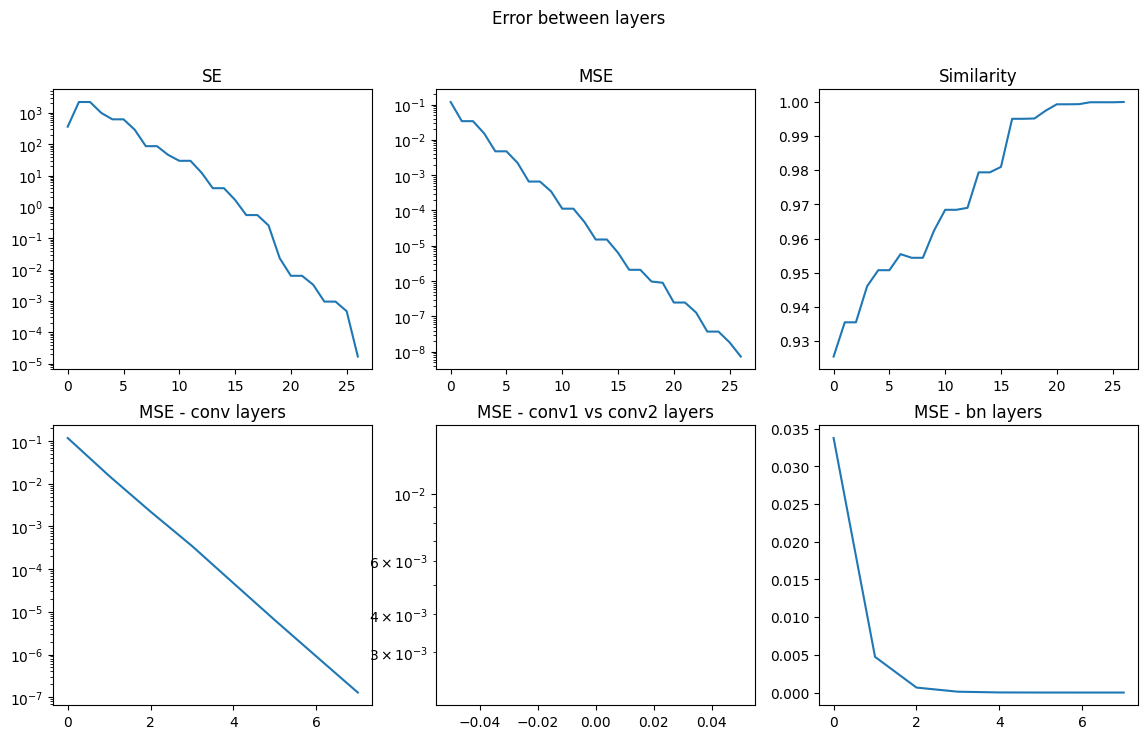

In [16]:
data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

# 노이즈 추가 버전

It: 0. Rec. loss: 0.9994.
It: 500. Rec. loss: 0.9984.
It: 1000. Rec. loss: 0.9982.
It: 1500. Rec. loss: 0.9982.
It: 2000. Rec. loss: 0.9981.
It: 2500. Rec. loss: 0.9980.
It: 3000. Rec. loss: 0.9980.
It: 3500. Rec. loss: 0.9980.
It: 3999. Rec. loss: 0.9980.
Choosing optimal result ...
Optimal result score: 0.9980
Total time: 345.914514541626.


Text(0.5, 1.0, '[NOISE] Rec. loss: 0.9980 | MSE: 3.2016 | PSNR: 6.97 | FMSE: 1.4580e-07')

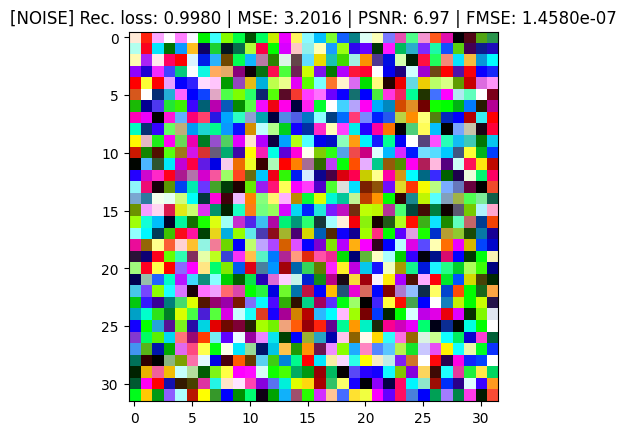

In [ ]:
########################################################################
# ★ 1) 모델 롤백
########################################################################
model.load_state_dict(model.state_dict())   # 사실상 롤백(No change)
model.zero_grad()

########################################################################
# ★ 2) 노이즈 버전 input_parameters 다시 계산
#     기존 코드 그대로 재사용 (복붙)
########################################################################
target_loss, _, _ = loss_fn(model(ground_truth), labels)

input_parameters_noisy = inversefed.reconstruction_algorithms.loss_steps(
    model, ground_truth, labels,
    lr=local_lr, local_steps=local_steps,
    use_updates=use_updates
)
input_parameters_noisy = [p.detach() for p in input_parameters_noisy]

# 여기에만 노이즈 추가
noise_scale = 0.05
input_parameters_noisy = [
    p + noise_scale * torch.randn_like(p) for p in input_parameters_noisy
]


########################################################################
# ★ 3) 기존 reconstruction 코드 "그대로" 다시 실행
########################################################################

rec_machine = inversefed.FedAvgReconstructor(
    model, (dm, ds),
    local_steps, local_lr,
    config,
    use_updates=use_updates
)

output_noisy, stats_noisy = rec_machine.reconstruct(
    input_parameters_noisy, labels, img_shape=(3, 32, 32)
)


########################################################################
# ★ 4) 기존 평가 코드 그대로 재사용
########################################################################
test_mse_noisy = (output_noisy.detach() - ground_truth).pow(2).mean()
feat_mse_noisy = (model(output_noisy.detach()) - model(ground_truth)).pow(2).mean()
test_psnr_noisy = inversefed.metrics.psnr(output_noisy, ground_truth, factor=1/ds)

plot(output_noisy)
plt.title(
    f"[NOISE] Rec. loss: {stats_noisy['opt']:2.4f} | "
    f"MSE: {test_mse_noisy:2.4f} | PSNR: {test_psnr_noisy:4.2f} | "
    f"FMSE: {feat_mse_noisy:2.4e}"
)

In [ ]:
# ★ 2) Noisy update 적용 후 loss 계산
model_noisy = copy.deepcopy(model)
with torch.no_grad():
    for p, upd in zip(model_noisy.parameters(), input_parameters_noisy):
        p -= local_lr * upd

loss_noisy_after, _, _ = loss_fn(model_noisy(ground_truth), labels)
delta_noisy = (target_loss - loss_noisy_after).item()

Text(0.5, 0.98, 'Error between layers (noisy)')

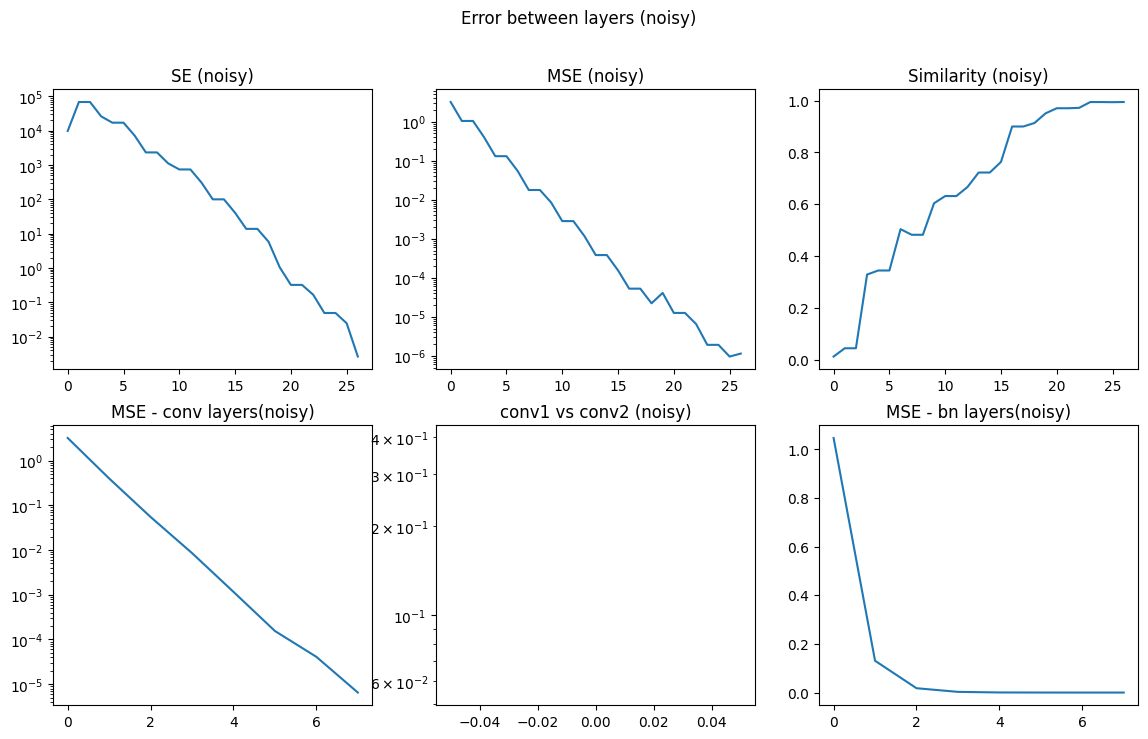

In [ ]:
# activation errors도 기존 코드 그대로 수행
data_noisy = inversefed.metrics.activation_errors(model, output_noisy, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data_noisy['se'].values())[:-3])
axes[0, 0].set_title('SE (noisy)')
axes[0, 1].semilogy(list(data_noisy['mse'].values())[:-3])
axes[0, 1].set_title('MSE (noisy)')
axes[0, 2].plot(list(data_noisy['sim'].values())[:-3])
axes[0, 2].set_title('Similarity (noisy)')

convs_noisy = [val for key, val in data_noisy['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs_noisy)
axes[1, 0].set_title('MSE - conv layers(noisy)')
convs_noisy = [val for key, val in data_noisy['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs_noisy)
convs_noisy = [val for key, val in data_noisy['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs_noisy)
axes[1, 1].set_title('conv1 vs conv2 (noisy)')

bns_noisy = [val for key, val in data_noisy['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns_noisy)
axes[1, 2].set_title('MSE - bn layers(noisy)')
fig.suptitle('Error between layers (noisy)')

In [ ]:
# ★ 3) 업데이트 효율 계산
utility = delta_noisy / delta_clean if delta_clean != 0 else 0

print("=== Update Utility (Loss Reduction Ratio) ===")
print(f"Clean loss reduction : {delta_clean:.6f}")
print(f"Noisy loss reduction : {delta_noisy:.6f}")
print(f"Utility (ratio)      : {utility:.6f}")
print("=============================================")

=== Update Utility (Loss Reduction Ratio) ===
Clean loss reduction : -0.000000
Noisy loss reduction : -0.000006
Utility (ratio)      : 27.000000


In [ ]:
# ★ 3) 업데이트 효율 계산
eps = 1e-12  # 0 나누기 방지용 작은 값

print("Raw deltas:", delta_clean, delta_noisy)  # 디버깅용 한 번 찍어보자

utility = delta_noisy / (delta_clean + eps)

print("=== Update Utility (Loss Reduction Ratio) ===")
print(f"Clean loss reduction : {delta_clean:.8e}")
print(f"Noisy loss reduction : {delta_noisy:.8e}")
print(f"Utility (ratio)      : {utility:.6f}")
print("=============================================")

Raw deltas: -2.384185791015625e-07 -6.4373016357421875e-06
=== Update Utility (Loss Reduction Ratio) ===
Clean loss reduction : -2.38418579e-07
Noisy loss reduction : -6.43730164e-06
Utility (ratio)      : 27.000113
